<a href="https://colab.research.google.com/github/SballarinAndre/Disciplina-Nexus/blob/main/analisesCABra_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
import gc
import cftime
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [70]:
# Finding CABRa attributes csv files
pathFiles = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/')
cabraAttributesFiles = pathFiles.rglob('*.csv')


In [71]:
# Reading files
dfs = []
for file in cabraAttributesFiles:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=',')
    dfs.append(df)

/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Streamflow_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset _Additional_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset _Climate_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Groundwater_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Hydrologic_disturbance_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Land_cover_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/cabra_general_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/cabra_Geology_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_soil_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_topography_attributes.csv


In [72]:
# Merging DataFrames
dfMerged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [73]:
dfMerged.columns

Index(['CABra ID', 'ANA ID', 'q_mean', 'q_1', 'q_5', 'q_95', 'q_99', 'q_lf',
       'q_ld', 'q_hf', 'q_hd', 'q_hfd', 'q_zero', 'q_cv', 'q_lcv', 'q_hcv',
       'q_elasticity', 'fdc_slope', 'baseflow_index', 'runoff_coef',
       'q_annual', 'q_baseflow_annual', 'q_quickflow_annual',
       'longitude_centroid', 'latitude_centroid', 'dist_coast', 'clim_p',
       'clim_tmin', 'clim_tmax', 'clim_rh', 'clim_wind', 'clim_srad',
       'clim_et', 'clim_pet', 'aridity_index', 'p_seasonality', 'clim_quality',
       'aquif_name', 'aquif_type', 'catch_wtd', 'catch_hand', 'hand_class',
       'dist_urban', 'cover_urban_x', 'cover_crops_x', 'res_number',
       'res_area', 'res_volume', 'res_regulation', 'water_demand',
       'hdisturb_index', 'cover_main', 'cover_bare', 'cover_forest',
       'cover_crops_y', 'cover_grass', 'cover_moss', 'cover_shrub',
       'cover_urban_y', 'cover_snow', 'cover_waterp', 'cover_waters',
       'ndvi_djf', 'ndvi_mam', 'ndvi_jja', 'ndvi_son', 'longitude', 'lati

In [74]:
#Values for annual time-scale
dfMerged['q_mean_annual'] = dfMerged['q_mean']*365.2666
dfMerged['clim_p_annual'] = dfMerged['clim_p']*365.2666
dfMerged['clim_pet_annual'] = dfMerged['clim_pet']*365.2666

In [75]:
# Calculating ECI (Liu et al. (2020))
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
dfMerged['ECI'] = np.log10(dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et']))
dfMerged['Aeff/Atopo'] = dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [77]:
#Filtering catchments - Excluding catchments with runoff coeficient > 1 and/or null values of ECI
dfFinal = dfMerged[dfMerged['runoff_coef'] < 1]
dfFinal = dfFinal[dfFinal['ECI'].notnull()]

In [ ]:
dfFinal.describe()

(0.0, 1.0)

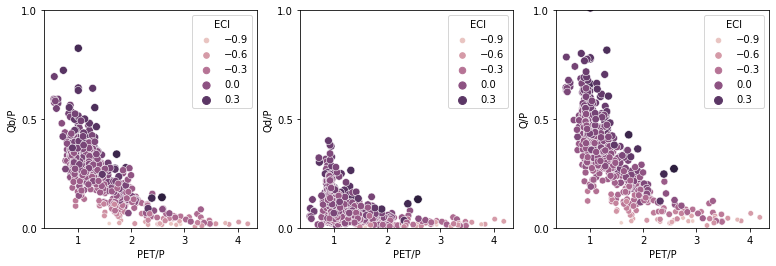

In [78]:
# Plot of Qb (baseflow) Qd (quickflow) and Q (mean total flow) fractions (fraction of P)
# classifying catchments according to ECI

hueC = 'ECI'
sizeC = 'ECI'

fig,ax = plt.subplots(ncols=3, figsize=(13,4))

sns.scatterplot(x=(dfFinal['aridity_index']), 
                # color = 'green', 
                hue = hueC, size = sizeC,
                     y=(dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[0])

ax[0].set_xlabel('PET/P')
ax[0].set_ylabel('Qb/P')



sns.scatterplot(x=(dfFinal['aridity_index']),
                # color = 'red', 
                hue = hueC, size = sizeC,
                     y=(dfFinal['q_quickflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[1])

ax[1].set_xlabel('PET/P')
ax[1].set_ylabel('Qd/P')

sns.scatterplot(x=(dfFinal['aridity_index']), 
                # color = 'black', 
                hue = hueC, size = sizeC,
                     y=(dfFinal['q_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[2])

ax[2].set_xlabel('PET/P')
ax[2].set_ylabel('Q/P')

ax[0].set_yticks([0,0.5,1])
ax[1].set_yticks([0,0.5,1])
ax[2].set_yticks([0,0.5,1])

ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[2].set_ylim([0,1])



Text(0, 0.5, 'Qb')

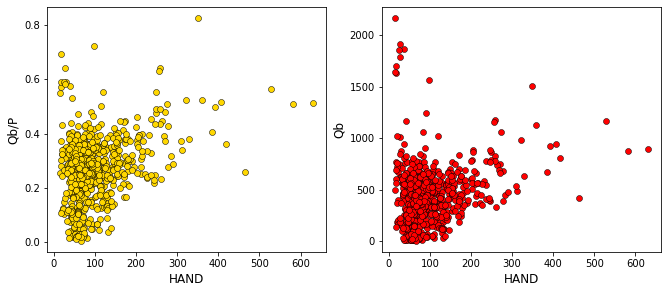

In [79]:
# Plot of Qb (baseflow) and P (precipitation)
# 
fig,ax = plt.subplots(ncols=2, figsize=(11,4.5))

sns.scatterplot(x=(dfFinal['catch_hand']), color = 'gold', edgecolor = 'black',
                     y=(dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual']), data=dfFinal, alpha=1, ax = ax[0])
ax[0].set_xlabel('HAND', fontsize = 12)
ax[0].set_ylabel('Qb/P', fontsize = 12)

sns.scatterplot(x=(dfFinal['catch_hand']), color = 'red',edgecolor = 'black',
                     y=(dfFinal['q_baseflow_annual']), data=dfFinal,alpha=1, ax = ax[1])
ax[1].set_xlabel('HAND', fontsize = 12)
ax[1].set_ylabel('Qb', fontsize = 12)


In [ ]:
#CALIBRATION + VALIDATION (Meira Neto et al. (2020) = https://doi.org/10.1029/2020WR027123)
#Setting number of repetitions
nBoot = 20

#Final dataFrame with parameters values and performance metrics
dfValues_Final = pd.DataFrame([])

#defining function-CurveFit_______________________________________________________________________________
#funcD - function of quickflow
#funcB - function of baseflow
#funcR - function of total flow

#loop in the calibration/validation process for different values of deltaD (D)
for D in np.arange(0.2,0.8,0.01):

  def funcD(x,a,b):
    return (np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b

  def funcB(x,c,d):
    return (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d

  def funcR(x,a,b,c,d):
    return ((np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b + (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d)


#_________________________________________________________________________________________________________
  #Fitting Curve using Levenberg-Marquardt algorithm
  #Empty list of parameters
  a = []
  b = []
  c = []
  d = []
  #Empty list of R² (coefficient of determination)
  r2_D = []
  r2_B = []
  r2_Q = []
  r2_w = []
  r2_e = []



  #for each value of D (from 0.2 to 0.8, step = 0.01), define parameters and R² 100 times, to obtain mean and std values
  for i in range(nBoot):
    # select a random sample (n = 365 -> half of the total sample = 731) of catchments, without replacement
    dfCalibration = dfFinal.sample(n = int(len(dfFinal)/2))
    #Validation is the complementary sample
    dfValidation  = dfFinal.drop(dfCalibration.index)

    #Calibration  values of the reduced sample, with x = aridity index, yD = direct flow, yB = baseflow, yQ = total flow
    x_cal = np.array(dfCalibration['aridity_index'])
    yD_cal = np.array(dfCalibration['q_quickflow_annual']/dfCalibration['clim_p_annual'])
    yB_cal = np.array(dfCalibration['q_baseflow_annual']/dfCalibration['clim_p_annual'])
    yQ_cal = np.array(dfCalibration['q_annual']/dfCalibration['clim_p_annual'])


    #Validation  values of the reduced sample, with x = aridity index, yD = direct flow, yB = baseflow, yQ = total flow
    #p = precipation, w = catchment wetting, e = evapotranspiration
    x_val = np.array(dfValidation['aridity_index'])
    p_val  = np.array(dfValidation['clim_p_annual'])
    qB_val = np.array(dfValidation['q_baseflow_annual'])
    qD_val = np.array(dfValidation['q_quickflow_annual'])
    qQ_val = np.array(dfValidation['q_annual'])
    w_val  = p_val - qD_val
    e_val  = w_val - qB_val


    #Curve fit to the reduced calibration sample
    poptD,pcovD = curve_fit(funcD,x_cal,yD_cal)
    poptB,pcovB = curve_fit(funcB,x_cal,yB_cal)

    #Saving parameters of the curve
    a.append(poptD[0])
    b.append(poptD[1])
    c.append(poptB[0])
    d.append(poptB[1])

    #Estimating values of qB (baseflow), qD (quickflow), qD(total flow), w (catchment wetting)
    #and e (evapotranspiration) using the fitted curve
    yD_est = funcD(x_val,poptD[0], poptD[1])
    yB_est = funcB(x_val,poptB[0], poptB[1])
    yQ_est = funcR(x_val,poptD[0], poptD[1], poptB[0], poptB[1])
    qB_est = yB_est*p_val
    qD_est = yD_est*p_val
    qQ_est = yQ_est*p_val
    w_est  = p_val - qD_est
    e_est  = w_est - qB_est

    #Saving R² score for each repetition
    r2_D.append(r2_score(qD_val,qD_est))
    r2_B.append(r2_score(qB_val,qB_est))
    r2_Q.append(r2_score(qQ_val,qQ_est))
    r2_w.append(r2_score(w_val,w_est))
    r2_e.append(r2_score(e_val,e_est))

  #Mean and Std values (considering 100 repetitions) for each D 
  r2_Dmean = np.mean(r2_D)
  r2_Bmean = np.mean(r2_B)
  r2_Qmean = np.mean(r2_Q)
  r2_wmean = np.mean(r2_w)
  r2_emean = np.mean(r2_e)
  a_mean = np.mean(a)
  b_mean = np.mean(b)
  c_mean = np.mean(c)
  d_mean = np.mean(d)

  r2_Dstd = np.std(r2_D)
  r2_Bstd = np.std(r2_B)
  r2_Qstd = np.std(r2_Q)
  r2_wstd = np.std(r2_w)
  r2_estd = np.std(r2_e)
  a_std = np.std(a)
  b_std = np.std(b)
  c_std = np.std(c)
  d_std = np.std(d)


  #Saving results
  dfValues = pd.DataFrame({'D':D,
                               'a_mean':a_mean,
                               'b_mean':b_mean,
                               'c_mean':c_mean,
                               'd_mean':d_mean,
                               'a_std':a_std,
                               'b_std':b_std,
                               'c_std':c_std,
                               'd_std':d_std,
                               'r2_Dmean': r2_Dmean,
                               'r2_Bmean': r2_Bmean,
                               'r2_Qmean': r2_Qmean,
                               'r2_wmean': r2_wmean,
                               'r2_emean': r2_emean,
                               'r2_Dstd': r2_Dstd,
                               'r2_Bstd': r2_Bstd,
                               'r2_Qstd': r2_Qstd,
                               'r2_wstd': r2_wstd,
                               'r2_estd': r2_estd}, index = [D])
  dfValues_Final = pd.concat([dfValues_Final,dfValues])  



dfValues_Final.to_csv('/content/drive/MyDrive/Colab Notebooks/resultsFinal.csv')

#   #Dataframe with parameters estimated to the nBoot-reduced samples
#   # dfParameters_metrics = pd.DataFrame()


In [80]:
#TESTE -> final values, using D = 0.40
D = 0.40
def funcD_final(x,a,b):
  return (np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b

def funcB_final(x,c,d):
  return (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d

def funcR_final(x,a,b,c,d):
  return ((np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b + (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.3, 0.83, '(f)')

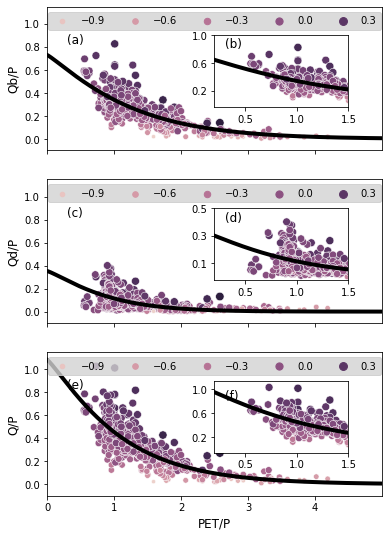

In [81]:
#Plotting cachment points + fitted curve
hueC = 'ECI'
sizeC = 'ECI'

#Final values for par (D = 0.40)
par_aFinal= 1.20791353049182
par_bFinal= 1.12689643769634
par_cFinal= 1.13989239005308
par_dFinal= 0.7617395682361

xLine = np.linspace(0,6,1000)
yLineD = funcD_final(xLine, par_aFinal,par_bFinal)
yLineB = funcB_final(xLine,par_cFinal, par_dFinal)
yLineR = funcR_final(xLine,par_aFinal,par_bFinal, par_cFinal, par_dFinal)

# yD_EST = funcD_final(dfFinal['aridity_index'],par_aFinal,par_bFinal)
# yB_EST = funcB_final(dfFinal['aridity_index'],par_cFinal,par_dFinal)

# r2d = r2_score((dfFinal['q_quickflow_annual']/dfFinal['clim_p_annual']), yD_EST)
# r2b = r2_score((dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual']), yB_EST)

fig, ax = plt.subplots(nrows = 3, figsize = (6,9), sharex = True)

axins0 = ax[0].inset_axes([0.5, 0.3, 0.4, 0.5])
axins1 = ax[1].inset_axes([0.5, 0.3, 0.4, 0.5])
axins2 = ax[2].inset_axes([0.5, 0.3, 0.4, 0.5])

sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC, 
                     y=(dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[0])

sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC,
                     y=(dfFinal['q_baseflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = axins0)


sns.lineplot(xLine,yLineB, color = 'black', linewidth = 4, ax = ax[0])
sns.lineplot(xLine,yLineB, color = 'black', linewidth = 4, ax = axins0)


ax[0].set_xlabel('PET/P', fontsize = 12)
ax[0].set_ylabel('Qb/P', fontsize = 12)
ax[0].set_ylim([-0.1,1.15])
ax[0].set_xlim([0, 5])
ax[0].set_xticks([0,1,2,3,4])
ax[0].legend(ncol = 5,loc = 'upper center', facecolor = 'lightgray')
ax[0].text(0.3,0.83,'(a)', fontsize = 12)
axins0.set_xlim([0.2,1.5])
axins0.set_xticks([0.5,1.0,1.5])
axins0.set_yticks([0.2,0.6,1.0])
axins0.set_xlabel('')
axins0.set_ylabel('')
axins0.legend().set_visible(False)
axins0.text(0.3,0.83,'(b)', fontsize = 12)



sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC, 
                     y=(dfFinal['q_quickflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[1])



sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC, 
                     y=(dfFinal['q_quickflow_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = axins1)


sns.lineplot(xLine,yLineD, color = 'black', linewidth = 4, ax = ax[1])
sns.lineplot(xLine,yLineD, color = 'black', linewidth = 4, ax = axins1)


ax[1].set_xlabel('PET/P', fontsize = 12)
ax[1].set_ylabel('Qd/P', fontsize = 12)
ax[1].set_ylim([-0.1,1.15])
ax[1].set_xlim([0,5])
ax[1].set_xticks([0,1,2,3,4])
ax[1].legend(ncol = 5,loc = 'upper center', facecolor = 'lightgray')
ax[1].text(0.3,0.83,'(c)', fontsize = 12)
axins1.set_xlim([0.2,1.5])
axins1.set_xticks([0.5,1.0,1.5])
axins1.set_yticks([0.1,0.3,0.5])
axins1.set_xlabel('')
axins1.set_ylabel('')
axins1.legend().set_visible(False)
axins1.text(0.3,0.40,'(d)', fontsize = 12)

sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC, 
                     y=(dfFinal['q_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = ax[2])

sns.scatterplot(x=(dfFinal['aridity_index']), 
                hue = hueC, size = sizeC,
                     y=(dfFinal['q_annual']/dfFinal['clim_p_annual']), data=dfFinal,alpha=1, ax = axins2)


sns.lineplot(xLine,yLineR, color = 'black', linewidth = 4, ax = ax[2])
sns.lineplot(xLine,yLineR, color = 'black', linewidth = 4, ax = axins2)


ax[2].set_xlabel('PET/P', fontsize = 12)
ax[2].set_ylabel('Q/P', fontsize = 12)
ax[2].set_ylim([-0.1,1.15])
ax[2].set_xlim([0, 5])
ax[2].set_xticks([0,1,2,3,4])
ax[2].legend(ncol = 5,loc = 'upper center', facecolor = 'lightgray')
ax[2].text(0.3,0.83,'(e)', fontsize = 12)
axins2.set_xlim([0.2,1.5])
axins2.set_xticks([0.5,1.0,1.5])
axins2.set_yticks([0.2,0.6,1.0])
axins2.set_xlabel('')
axins2.set_ylabel('')
axins2.legend().set_visible(False)
axins2.text(0.3,0.83,'(f)', fontsize = 12)




(0.0, 2700.0)

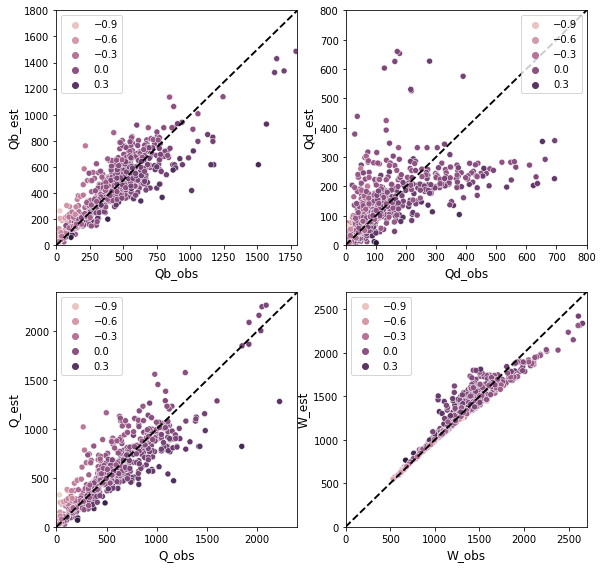

In [ ]:
#Plotting Q-Q plots (observed x estimated)

hueC = 'ECI'
sizeC = 'ECI'

D = 0.4
def funcD_teste(x,a,b):
    return (np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b

def funcB_teste(x,c,d):
    return (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d
def funcR_teste(x,a,b,c,d):
    return ((np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b + (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d)

par_aFinal= 1.20791353049182
par_bFinal= 1.12689643769634
par_cFinal= 1.13989239005308
par_dFinal= 0.7617395682361

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB = dfFinal['q_baseflow_annual']
qD = dfFinal['q_quickflow_annual']
q  = dfFinal['q_annual']
w  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual']

yD_est = funcD(x,par_aFinal, par_bFinal)
yB_est = funcB(x,par_cFinal, par_dFinal)
yQ_est = funcR(x,par_aFinal, par_bFinal, par_cFinal, par_dFinal)
qB_est = yB_est*p
qD_est = yD_est*p
qQ_est = yQ_est*p
w_est  = p - qD_est

dfQQ = pd.DataFrame({'x':x,
                     'p':p,
                     'qB':qB,
                     'qD':qD,
                     'qQ' :q,
                     'w' :w, 
                     'qB_est':qB_est,
                     'qD_est':qD_est,
                     'qQ_est':qQ_est,
                     'w_est':w_est,
                     'ECI':np.array(dfFinal['ECI']), 
                     })

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (9.5,9.5))



sns.scatterplot(x=(dfQQ['qB']), 
                hue = 'ECI', 
                     y=(dfQQ['qB_est']), data=dfQQ, alpha=1, ax = ax[0,0])
sns.scatterplot(x=(dfQQ['qD']), 
                hue = 'ECI', 
                     y=(dfQQ['qD_est']), data=dfQQ, alpha=1, ax = ax[0,1])
sns.scatterplot(x=(dfQQ['qQ']), 
                hue = 'ECI', 
                     y=(dfQQ['qQ_est']), data=dfQQ, alpha=1, ax = ax[1,0])
sns.scatterplot(x=(dfQQ['w']), 
                hue = 'ECI', 
                     y=(dfQQ['w_est']), data=dfQQ, alpha=1, ax = ax[1,1])

sns.lineplot(x = [0,1800],y = [0,1800], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[0,0])
sns.lineplot(x = [0,800],y = [0,800], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[0,1])
sns.lineplot(x = [0,2500],y = [0,2500], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[1,0])
sns.lineplot(x = [0,2700],y = [0,2700], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[1,1])




ax[0,0].set_xlabel('Qb_obs', fontsize = 12)
ax[0,0].set_ylabel('Qb_est', fontsize = 12)
ax[0,1].set_xlabel('Qd_obs', fontsize = 12)
ax[0,1].set_ylabel('Qd_est', fontsize = 12)
ax[1,0].set_xlabel('Q_obs', fontsize = 12)
ax[1,0].set_ylabel('Q_est', fontsize = 12)
ax[1,1].set_xlabel('W_obs', fontsize = 12)
ax[1,1].set_ylabel('W_est', fontsize = 12)

ax[0,0].set_xlim([0,1800])
ax[0,0].set_ylim([0,1800])
ax[0,1].set_xlim([0,800])
ax[0,1].set_ylim([0,800])
ax[1,0].set_xlim([0,2400])
ax[1,0].set_ylim([0,2400])
ax[1,1].set_xlim([0,2700])
ax[1,1].set_ylim([0,2700])



(0.0, 3000.0)

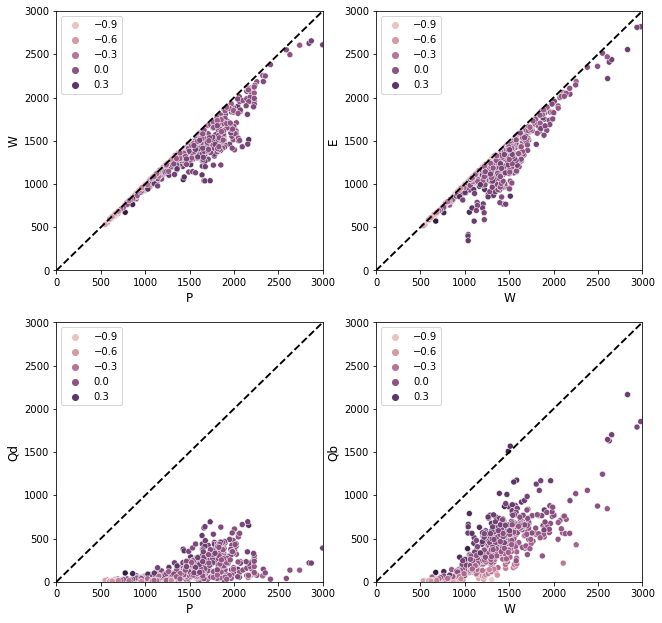

In [ ]:
#Plotting Figure 3 of Meira Neto et al. (2020)

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB = dfFinal['q_baseflow_annual']
qD = dfFinal['q_quickflow_annual']
q  = dfFinal['q_annual']
w  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual']
e  = w - qD


dfPlot = pd.DataFrame({'x':x,
                     'p':p,
                     'qB':qB,
                     'qD':qD,
                     'qQ' :q,
                     'w' :w, 
                     'e':e,
                     'ECI':np.array(dfFinal['ECI']), 
                     })

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10.5,10.5))



sns.scatterplot(x=(dfPlot['p']), 
                hue = 'ECI', 
                     y=(dfPlot['w']), data=dfPlot, alpha=1, ax = ax[0,0])
sns.scatterplot(x=(dfPlot['w']), 
                hue = 'ECI', 
                     y=(dfPlot['e']), data=dfPlot, alpha=1, ax = ax[0,1])
sns.scatterplot(x=(dfPlot['p']), 
                hue = 'ECI', 
                     y=(dfPlot['qD']), data=dfPlot, alpha=1, ax = ax[1,0])
sns.scatterplot(x=(dfPlot['w']), 
                hue = 'ECI', 
                     y=(dfPlot['qB']), data=dfPlot, alpha=1, ax = ax[1,1])

sns.lineplot(x = [0,3000],y = [0,3000], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[0,0])
sns.lineplot(x = [0,3000],y = [0,3000], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[0,1])
sns.lineplot(x = [0,3000],y = [0,3000], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[1,0])
sns.lineplot(x = [0,3000],y = [0,3000], color = 'black', linestyle = '--', linewidth = 1.9, ax = ax[1,1])




ax[0,0].set_xlabel('P', fontsize = 12)
ax[0,0].set_ylabel('W', fontsize = 12)
ax[0,1].set_xlabel('W', fontsize = 12)
ax[0,1].set_ylabel('E', fontsize = 12)
ax[1,0].set_xlabel('P', fontsize = 12)
ax[1,0].set_ylabel('Qd', fontsize = 12)
ax[1,1].set_xlabel('W', fontsize = 12)
ax[1,1].set_ylabel('Qb', fontsize = 12)

ax[0,0].set_xlim([0,3000])
ax[0,0].set_ylim([0,3000])
ax[0,1].set_xlim([0,3000])
ax[0,1].set_ylim([0,3000])
ax[1,0].set_xlim([0,3000])
ax[1,0].set_ylim([0,3000])
ax[1,1].set_xlim([0,3000])
ax[1,1].set_ylim([0,3000])

